# Particle Filter for Induction Motor Model

We had developed Kalman Filter, Extended Kalman Filter and Unscented Kalman filter for induction motor state space model. We also built Particle Filter for robot in a room. This notebook uses particle filter to estimate states of an induction motor using the same state space model and slight modification to the Particle Filter Algorithm

## Induction Motor Model and simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import random
import scipy.integrate as sp

In [2]:
class IMotor(object):
    
    def __init__(self):
        
        #States
        self.x1=0.2
        self.x2=-0.6
        self.x3=-0.4
        self.x4=0.1
        self.x5=0.3
        
        #Parameters
        self.k1=-0.186
        self.k2=0.178
        self.k3=0.225
        self.k4=-0.234
        self.k5=-0.081
        self.k6=4.643
        self.k7=-4.448
        self.k8=1
        
    def y1(self):
        return self.k7*self.x1+self.k8*self.x3
    
    def y2(self):
        return self.k7*self.x2+self.k8*self.x4
    
    def dxdt(self, z):
        
        z1=z[0]
        z2=z[1]
        z3=z[2]
        
        dx1dt = self.k1*self.x1 + z1*self.x2 + self.k2*self.x3 + z2
        dx2dt = -z1*self.x1 + self.k1*self.x2 + self.k2*self.x4
        dx3dt = self.k3*self.x1 + self.k4*self.x3 + (z1-self.x5)*self.x4
        dx4dt = self.k3*self.x2 - (z1-self.x5)*self.x3 + self.k4*self.x4
        dx5dt = self.k5*(self.x1*self.x4-self.x2*self.x3)+self.k6*z3
        
        return np.array([dx1dt, dx2dt, dx3dt, dx4dt, dx5dt])
        
    def setState(self, X):
        self.x1=X[0]
        self.x2=X[1]
        self.x3=X[2]
        self.x4=X[3]
        self.x5=X[4]
        
    def setX5(x5):
        self.x5=x5
    
        
    def getState(self):
        
        return np.array([self.x1, self.x2, self.x3, self.x4, self.x5])
    
    def update(self, delt, z, noise=False):
        #Use RK4 method to integrate
        
        #Initialise
        h=delt
        X0=self.getState()
        
        #K1 terms
        K1=h*self.dxdt(z)
        X1=X0+K1/2
        self.setState(X1)
        
        #K2 terms
        K2=h*self.dxdt(z)
        X2=X0+K2/2
        self.setState(X2)
        
        #K3 terms
        K3=h*self.dxdt(z)
        X3=X0+K3
        self.setState(X3)
        
        #K4 terms
        K4=h*self.dxdt(z)
        X=X0+K1/6+K2/3+K3/3+K4/6
        if noise==True:
            Qd=np.identity(5)*1e-4
            X+=np.random.multivariate_normal([0, 0, 0, 0, 0], Qd)
        self.setState(X)
        
        
    def linMod(self, Z):
        
        Z1=Z[0]
        Z2=Z[1]
        Z3=Z[2]
        
        X=self.getState()
        X1=X[0]
        X2=X[1]
        X3=X[2]
        X4=X[3]
        X5=X[4]
        
        a1=[self.k1, Z1, self.k2, 0, 0]
        a2=[-Z1, self.k1, 0, self.k2, 0]
        a3=[self.k3, 0, self.k4, (Z1-X5), -X4]
        a4=[0, self.k3, -(Z1-X5), self.k4, X3]
        a5=[self.k5*X4, -self.k5*X3, -self.k5*X2, self.k5*X1, 0]
        
        A=[a1, a2, a3, a4, a5]
        A=np.array(A)
        
        c1=[X2, 1, 0]
        c2=[-X1, 0, 0]
        c3=[X4, 0, 0]
        c4=[-X3, 0, 0]
        c5=[0, 0, self.k6]
        
        D=[c1, c2, c3, c4, c5]
        D=np.array(D)
        
        return A, D
        
    def meas(self, noise=False):
        
        x=self.getState()
        y1=self.k7*x[0]+self.k8*x[2]
        y2=self.k7*x[1]+self.k8*x[3]
        Y=np.array([y1, y2])
        
        if noise:
            R=np.identity(2)*1e-2
            Y+=np.random.multivariate_normal([0, 0], R)
        
        return Y
    
    def linMeas(self):
        
        y1=[self.k7, 0, self.k8, 0, 0]
        y2=[0, self.k7, 0, self.k8, 0]
        
        
        C=[y1, y2]
        
        return np.array(C)
        
        

def Fx(Xi, dt, Z):
    
    a=IMotor()
    a.setState(Xi)
    a.update(dt, Z)
    return a.getState()


def Gx(X):
    
    x1=X[0]
    x2=X[1]
    x3=X[2]
    x4=X[3]
    
    k7=-4.448
    k8=1
    
     
    y1 = k7*x1 + k8*x3
    y2 = k7*x2 + k8*x4
    
    return np.array([y1, y2])

## Modified Particle Filter

With slight modifications, the filter is implemented for state estimation of Induction Motor.
The Particle class prop function just accepts Z, t which are input and time step and performs the propagation as per the model. The 'meas' function directly returns the measurement as per 'Gx' (the measurement model) function. Basically, to suit our needs for this model, we removed some generality and modified code to make it thinner.

The 'ParticleFilter' Class has attributes Ps, Count, limits, dSum which are particles list, number of particles, limits as was in robot simulation here its value is kept as [[-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1]], and sum of weights respectively. the function RandsomSample initialises the filter same as before. The function Propx propagates all the particles. The function getStats returns the weighted mean of all the current samples

The Resample function now takes two arguments Xt, y (state estimate and measurement). It computes distance of each particle estimated measurement form actual measurement and assigns weight to particle '$i$' proportional to $1-d_i/\Sigma_j d_j$, where $d$ is distance such that sum of all weights is equal. A particle is retained with probability $w/2$ where w is its weight. Then to make up for the lost particles, new particles are generated with estimates distributed as $Xt+s$, where $s$ is a random vector sampled uniformly from limits, 'Xt' here is passed on as previous step estimate of X. Then we create measurement estimate and if its close enough to original estimate we retain it. To decide if its close enough we obtain its rough approx weight which is $1-d/D$, where $d$ is distance of this new particle, $D$ denotes sum of distances of retained particles. If this weight is greater than certain value (0.8 here), we retain the particle.



In [3]:
class Particle(object):
    
    def __init__(self):
        
        self.X=np.zeros(5)
        self.w=0
        
    def getX(self):
        return self.X
    
    def setX(self, X):
        self.X=X
        
    def getW(self):
        return self.w
    
    def setW(self, w):
        self.w=w
        
    def prop(self, Z, t):
        self.X=Fx(self.X, t, Z)
        
    def meas(self):
        return Gx(self.X)
    

In [4]:
class ParticleFilter(object):
    
    def __init__(self):
        
        self.Ps=[]
        self.Count=0
        self.limits=[[-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1]]
        self.dSum=0
        
    def RandomSample(self, N=50):
        
        self.Count=N
        for i in range(N):
            X=np.zeros(5)
            for j in range(5):
                X[j]=random.uniform(*self.limits[j])
            P=Particle()
            P.setX(X)
            P.setW(1/N)
            self.dSum+=1/N
            self.Ps.append(P)
    
    def retVals(self, thresh=0):
        
        Data=np.zeros([5, self.Count])
        
        for i in range(self.Count):
            Data[:, i]=self.Ps[i].getX()
            
        return Data
    
    def Propx(self, Z=[1, 1, 0], t=0.1):
        
        for i in range(self.Count):
            self.Ps[i].prop(Z, t)
            
    def Resample(self, Xt, y):
        
        C=self.Count   #Store Original count
        B=[]           #New array
        self.dSum=0    #sum of distances
        Dis=[]
        for i in range(0, C):
            Y=self.Ps[i].meas()                   #Measurement
            d=sqrt((Y[1]-y[1])**2+(Y[0]-y[0])**2) #Distance
            self.dSum+=d                          #Total Sum
            Dis.append(d)                         #Array of distances
            
        Bcount=0       #No of values in B
        Bsum=0         #Sum of distances of B Particles
        
        for i in range(0, C):
            w=1-Dis[i]/self.dSum      #Compute expected weight w of a Particle in A
            a=random.uniform(0, 1)    #Store this particle in B with probability w/C
            if a<w/2:                 
                B.append(self.Ps[i])  #put it in B
                Bcount+=1             #increase count of B
                Bsum+=Dis[i]          #Update new sum
 
        if Bcount==0:
            Bcount+=1
            Bsum+=10
        #Keep having new values until the total count becomes same as before

        while Bcount<C:
            
            X=np.zeros(5)                
            for j in range(5):
                X[j]=random.uniform(Xt[j]+0.4, Xt[j]-0.4)   #Generate a random Sample
            
            Y=Gx(X)                                    #Generate its measurement
            d=sqrt((Y[1]-y[1])**2+(Y[0]-y[0])**2)      #Compute its distance
            if 1-d/Bsum>0.8:                   #If new sample is close enough
                #Store it
                P=Particle()
                P.setX(X)
                Bsum+=d
                Bcount+=1
                B.append(P)
                
        #Now B is good to go
        self.Ps=B
        self.Count=Bcount
        self.dSum=Bsum
        #Redestribute weights
        for i in range(self.Count):
            p=self.Ps[i]                          #hold a particle
            Y=p.meas()                            #Measurement
            d=sqrt((Y[1]-y[1])**2+(Y[0]-y[0])**2) #Distance
            w=(1-d/Bsum)/(self.Count-1)
            p.setW(w)
        
        
    def getStats(self):
        
        xm=np.zeros(5)
        for i in self.Ps:
            x=i.getX()
            w=i.getW()
            xm+=x*w
            
        return xm

### Simulation same as was done in KF, EKF and UKF

In [5]:
a=IMotor()
X=a.getState()
Xall=[]
U1=[]
U2=[]
Y1=[]
Y2=[]
C=a.linMeas()
for i in range(0, 600):
    U1.append(1)
    U2.append(1)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X=a.getState()
    Xall.append(X)
    y=a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
for i in range(600, 900):
    U1.append(1.2)
    U2.append(1)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X=a.getState()
    Xall.append(X)
    y=a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
for i in range(900, 1200):
    U1.append(0.8)
    U2.append(1)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X=a.getState()
    Xall.append(X)
    y=a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
for i in range(1200, 1500):
    U1.append(1)
    U2.append(1.2)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X=a.getState()
    Xall.append(X)
    y=a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
Y1=np.array(Y1)
Y2=np.array(Y2)
Xall=np.array(Xall)

### Particle Filter Estimation

In [6]:
A=ParticleFilter()
A.RandomSample(100)
Xplot=[]
Xt=np.zeros(5)
T=0.1
Z=[1, 1, 0]
for i in range(1500):
    Z=[U1[i], U2[i], 0]
    A.Propx(Z, T)
    y=np.array([Y1[i], Y2[i]])
    Xt=A.getStats()
    Xplot.append(Xt)
    A.Resample(Xt, y)
Xplot=np.array(Xplot)

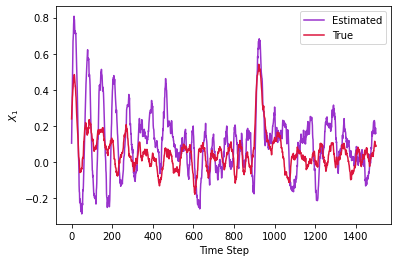

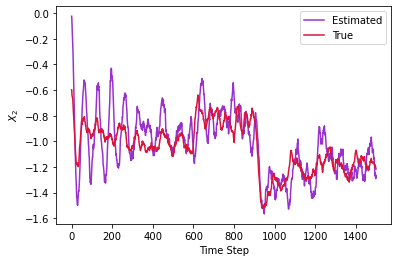

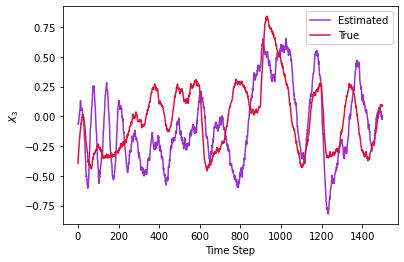

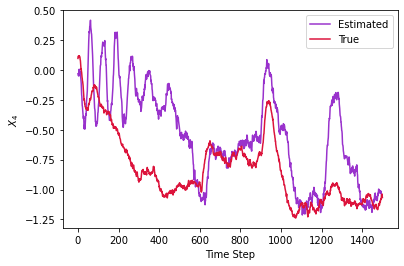

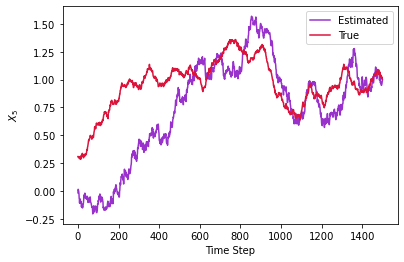

In [7]:
plt.plot(Xplot[:, 0], 'darkorchid')
plt.plot(Xall[:, 0], 'crimson')
plt.xlabel('Time Step')
plt.ylabel('$X_1$')
plt.legend(['Estimated', 'True'])
plt.savefig('Pfx1.png')
plt.show()

plt.plot(Xplot[:, 1], 'darkorchid')
plt.plot(Xall[:, 1], 'crimson')
plt.xlabel('Time Step')
plt.ylabel('$X_2$')
plt.legend(['Estimated', 'True'])
plt.savefig('Pfx2.png')
plt.show()

plt.plot(Xplot[:, 2], 'darkorchid')
plt.plot(Xall[:, 2], 'crimson')
plt.xlabel('Time Step')
plt.ylabel('$X_3$')
plt.legend(['Estimated', 'True'])
plt.savefig('Pfx3.png')
plt.show()

plt.plot(Xplot[:, 3], 'darkorchid')
plt.plot(Xall[:, 3], 'crimson')
plt.xlabel('Time Step')
plt.ylabel('$X_4$')
plt.legend(['Estimated', 'True'])
plt.savefig('Pfx4.png')
plt.show()

plt.plot(Xplot[:, 4], 'darkorchid')
plt.plot(Xall[:, 4], 'crimson')
plt.xlabel('Time Step')
plt.ylabel('$X_5$')
plt.legend(['Estimated', 'True'])
plt.savefig('Pfx5.png')
plt.show()